In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import tickbars

In [3]:
raw_data = pd.read_csv('ESU13.csv')

In [4]:
raw_data['time'] = pd.to_datetime(raw_data['time'], format='%Y-%m-%d %H:%M:%S.%f')

In [5]:
raw_data.head()

,symbol,time,price,volume
0,ESU13,2013-09-01 17:00:00.083,1640.25,8
1,ESU13,2013-09-01 17:00:00.083,1640.25,1
2,ESU13,2013-09-01 17:00:00.083,1640.25,2
3,ESU13,2013-09-01 17:00:00.083,1640.25,1
4,ESU13,2013-09-01 17:00:00.083,1640.25,1


In [6]:
data_time_vwap = tickbars.create_bars(raw_data, pd.Grouper(key='time', freq='15Min'), tickbars.compute_bar)

In [7]:
num_ticks_per_bar = round(len(raw_data) / len(data_time_vwap), -3)
data_tick_vwap = tickbars.create_bars(
    raw_data.assign(grpId=lambda row: row.index // num_ticks_per_bar),
    'grpId',
    tickbars.compute_bar
)

In [8]:
data_cm_vol = raw_data.assign(cmVol=raw_data['volume'].cumsum()) 
vol_per_bar = round(data_cm_vol.cmVol.values[-1] / len(data_time_vwap), -2) # round to the nearest hundred
data_vol_vwap = tickbars.create_bars(
    data_cm_vol.assign(grpId=lambda row: row.cmVol // vol_per_bar),
    'grpId',
    tickbars.compute_bar
)

In [9]:
data_dv_vol = raw_data.assign(cmVol=(raw_data['volume']*raw_data['price']).cumsum())
dv_per_bar = round(data_dv_vol.cmVol.values[-1] / len(data_time_vwap), 0) # round to the nearest hundred
data_dv_vwap = tickbars.create_bars(
    data_dv_vol.assign(grpId=lambda row: row.cmVol // dv_per_bar),
    'grpId',
    tickbars.compute_bar
)

In [10]:
time_diff = data_time_vwap['close'].diff()/data_time_vwap['close'].shift(1)
tick_diff = data_tick_vwap['close'].diff()/data_tick_vwap['close'].shift(1)
volume_diff = data_vol_vwap['close'].diff()/data_vol_vwap['close'].shift(1)
dollar_diff = data_dv_vwap['close'].diff()/data_dv_vwap['close'].shift(1)

# Standardize the data
time_standard = (time_diff - time_diff.mean()) / time_diff.std()
tick_standard = (tick_diff - tick_diff.mean()) / tick_diff.std()
volume_standard = (volume_diff - volume_diff.mean()) / volume_diff.std()
dollar_standard = (dollar_diff - dollar_diff.mean()) / dollar_diff.std()

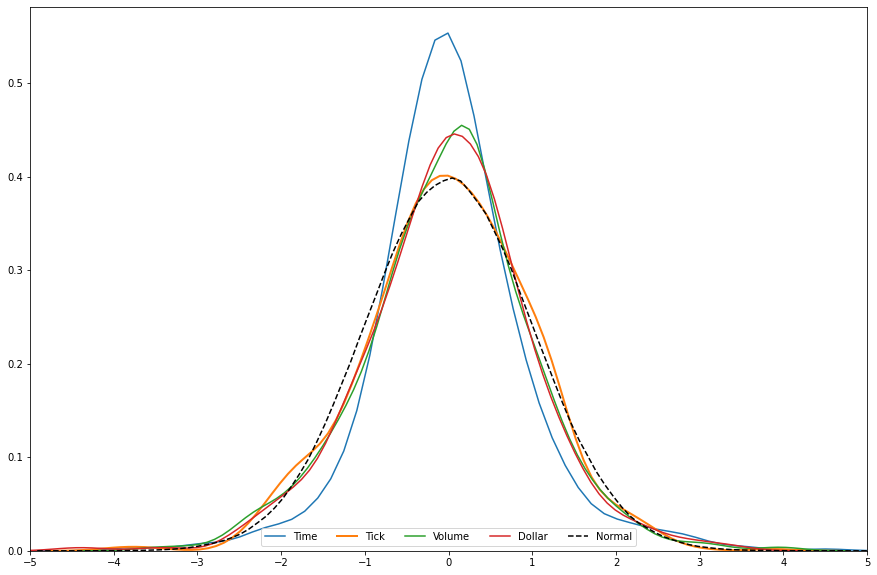

In [13]:
# Plot the Distributions
plt.figure(figsize=(15,10))
sns.kdeplot(time_standard, label="Time")
sns.kdeplot(tick_standard, label="Tick", linewidth=2)
sns.kdeplot(volume_standard, label="Volume")
sns.kdeplot(dollar_standard, label="Dollar")
sns.kdeplot(np.random.normal(size=1000000), label="Normal", color='black', linestyle="--")

# plt.yscale('log')
plt.xticks(range(-5, 6))
plt.legend(loc=8, ncol=5)
plt.xlim(-5, 5)
plt.show()